In [1]:
import sys
if not '/home/pop518504/git/asax-fabian' in sys.path:
    sys.path.insert(0, '/home/pop518504/git/gknet-benchmarks')
    
from misc.jax_nve_nl import NveSimulation
from matplotlib import pyplot as plt

In [2]:
from ase import Atoms
from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.calculators.lj import LennardJones

def initialize_system() -> Atoms:
    atoms = bulk("Ar", cubic=True) * [5, 5, 5]
    MaxwellBoltzmannDistribution(atoms, temperature_K=300)
    Stationary(atoms)
    atoms.calc = LennardJones(sigma=2.0, epsilon=1.5, rc=10.0, ro=6.0)  # TODO: Remove later
    return atoms

atoms = initialize_system()
# steps = 1000

In [102]:
from statistics import mean

def plot_runtimes(md, skip_outliers=False):
    plt.title("{}\ndt={}, n={}".format("Lennard-Jones (NL) Argon NVE runtime", md.dt, len(md.atoms)))
    plt.xlabel("Steps")
    plt.ylabel("Runtime [ms]")
    
    step_times = md.step_times_ms
    indices = list(range(len(step_times)))
    
    if skip_outliers:
        # skip initial NL calculation
        indices = indices[1:]
        step_times = step_times[1:]

        # skip NL recalculations
        nl_event_indices = list(map(lambda ne_idx: ne_idx - 1, md.nl_recalculation_events))  # we omit the first value: shift index by 1
                
        # if we want to remove these outliers (breaks up plot)
        # indices = list(map(lambda i: i if i not in nl_event_indices else None, indices))
        # step_times = list(map(lambda st: st if step_times.index(st) not in nl_event_indices else None, step_times))  
        
        # smooth with previous runtime instead (no breaking up)
        step_times = list(map(lambda st: st if step_times.index(st) not in nl_event_indices else step_times[step_times.index(st) - 1], step_times))  
        
        # scatter NL recalculation events w/ smoothed runtime
        nl_events = list(map(lambda i: step_times[i], nl_event_indices))
        plt.scatter(nl_event_indices, nl_events)

    plt.plot(indices, step_times)

In [105]:
md = NveSimulation(atoms, dt=1e-2)
md.run(steps=100)

NL overflow, recomputing...
NL overflow, recomputing...


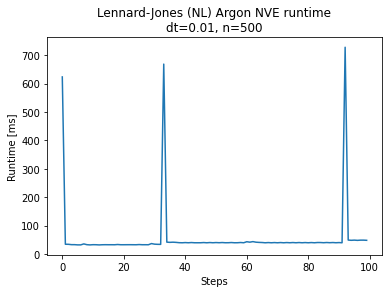

In [106]:
plot_runtimes(md)

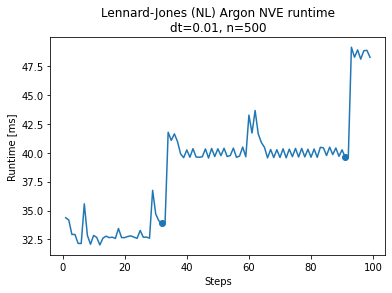

In [107]:
plot_runtimes(md, skip_outliers=True)